# BERT Tokenize Example

In [3]:
import torch
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

100%|██████████| 231508/231508 [00:00<00:00, 372444.35B/s]


In [4]:
tokenized_text

['[CLS]',
 'who',
 'was',
 'jim',
 'henson',
 '?',
 '[SEP]',
 'jim',
 'henson',
 'was',
 'a',
 'puppet',
 '##eer',
 '[SEP]']

In [5]:
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [6]:
# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
segments_tensors = segments_tensors.to('cuda')
model.to('cuda')

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]

# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
assert predicted_token == 'henson'
print('Predicted token is:',predicted_token)

100%|██████████| 440473133/440473133 [01:16<00:00, 5794211.03B/s]


Predicted token is: henson


# Bert Generation (Shakespear's sonnets)
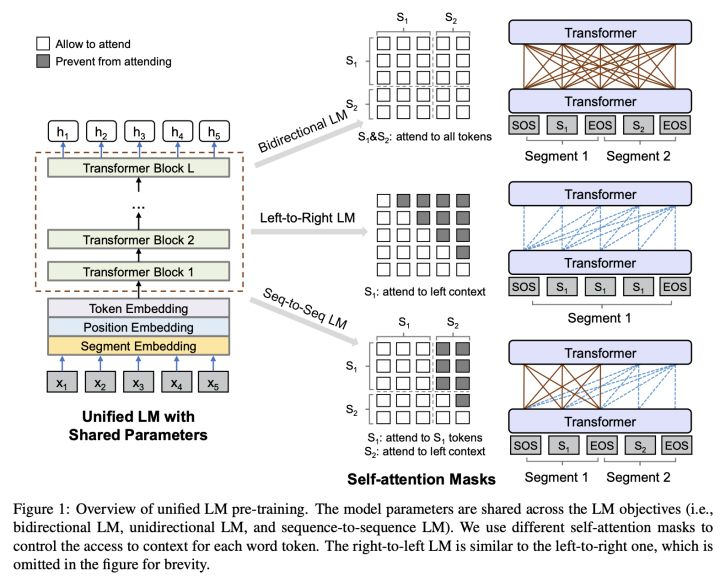

In [1]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

!unzip uncased_L-12_H-768_A-12.zip

--2020-03-26 15:42:32--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.199.16, 2404:6800:4005:802::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.199.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

100%[======================================>] 407,727,028  102MB/s   in 4.3s   

2020-03-26 15:42:37 (90.2 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [1]:
from collections import defaultdict
from bert4keras.models import build_transformer_model
import tensorflow as tf
from bert4keras.tokenizer import Tokenizer, load_vocab
from bert4keras.snippets import sequence_padding, DataGenerator
import numpy as np
from keras.optimizers import adam
from bert4keras.backend import K

Using TensorFlow backend.
/home/wzengad/anaconda3/envs/python36/lib/python3.6/site-packages/bert4keras/__init__.py:44: UserWarning: bert4keras.tokenizer has been renamed as bert4keras.tokenizers.
  warnings.warn('bert4keras.tokenizer has been renamed as bert4keras.tokenizers.')
/home/wzengad/anaconda3/envs/python36/lib/python3.6/site-packages/bert4keras/__init__.py:45: UserWarning: please use bert4keras.tokenizers.
  warnings.warn('please use bert4keras.tokenizers.')


## Using left-to-right mask

In [2]:
# load path of  pre-trained model parameters
config_path = "uncased_L-12_H-768_A-12/bert_config.json"
checkpoint_path = "uncased_L-12_H-768_A-12/bert_model.ckpt"
dict_path = "uncased_L-12_H-768_A-12/vocab.txt"
# disallowed_words
disallowed_words = []
# Maximum sentence length
max_len = 64
# Minimum word frequency
min_word_frequency = 1
train_epoch = 20
batch_size = 32

# Load the dataset
with open('shakespeare_filt_2.txt', 'r') as f:
    lines = f.readlines()
    lines = [line.replace('：', ':') for line in lines]
    
poetry = []
for line in lines:
    poetry.append(line)

# Dictionaries and tokenizers in pre-trained models
_token_dict = load_vocab(dict_path)
_tokenizer = Tokenizer(dict_path, do_lower_case=False)

# Count the frequency of all words
word_frequency_count = defaultdict(int)
for line in poetry:
    for t in _tokenizer.tokenize(line):
        word_frequency_count[t] += 1
# Filter out low frequency words
tokens = [(token, count) for token, count in word_frequency_count.items() if count >= min_word_frequency]
# Sort by word frequency
tokens = sorted(tokens, key=lambda x: -x[1])
# Remove word frequency, keep only word list
tokens = [token for token, count in tokens]

# Construct a new token-> id mapping relationship and a new vocabulary
token_id_dict = {}
keep_words = []

# Add special words to the dictionary: padding, low-frequency words, start tag, end tag
for token in ['[PAD]', '[UNK]', '[CLS]', '[SEP]']:
    token_id_dict[token] = len(token_id_dict)
    keep_words.append(_token_dict[token])
# Add words from the shakespeare's sonnets dataset to the dictionary
for token in tokens:
    # Words in bert's dictionary but not yet loaded into the new dictionary will be added
    if token in _token_dict and token not in token_id_dict:
        token_id_dict[token] = len(token_id_dict)
        keep_words.append(_token_dict[token])

# Rebuilding tokenizer with the new dictionary
tokenizer = Tokenizer(token_id_dict, do_lower_case=True)

print(len(poetry))
print(len(keep_words))


class PoetryDataGenerator(DataGenerator):
    """
    Data generator
    """

    def __iter__(self, random=False):
        # Shuffle data
        if random:
            np.random.shuffle(self.data)
        total = len(self.data)
        # Divided data into several batches
        for start in range(0, total, self.batch_size):
            end = min(start + self.batch_size, total)
            # Cache the list of batch data
            batch_token_ids = []
            batch_segment_ids = []
            for single_data in self.data[start:end]:
                # Process the data and add it to the cache list
                token_ids, segment_ids = tokenizer.encode(single_data)
                batch_token_ids.append(token_ids)
                batch_segment_ids.append(segment_ids)
            # padding
            batch_token_ids = sequence_padding(batch_token_ids)  #shape [32,16]
            batch_segment_ids = sequence_padding(batch_segment_ids)
            # yield the batch
            yield [batch_token_ids, batch_segment_ids], None

2155
3093


In [34]:
model = build_transformer_model(config_path, checkpoint_path, application='lm', keep_tokens=keep_words)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Embedding-Token (Embedding)     (None, None, 768)    2375424     Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, None, 768)    1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [5]:
y_true = model.input[0][:, 1:]
y_pred = model.output[:, :-1]
cross_entropy = K.sum(K.sparse_categorical_crossentropy(y_true, y_pred))
model.add_loss(cross_entropy)
model.compile(optimizer=adam(1e-5))
model_path='best_model.h5'

In [9]:
# Create data generator
data_generator = PoetryDataGenerator(poetry, batch_size=batch_size)
# Start training

model.fit_generator(data_generator.forfit(), steps_per_epoch=data_generator.steps, epochs=300)
#model.fit_generator(data_generator.forfit(), steps_per_epoch=data_generator.steps, epochs=300,callbacks=[Evaluate()])
model.save_weights(model_path)

In [35]:
model_path='best_model.h5'
model.load_weights(model_path)

In [36]:
s='shall i compare thee to a summer\'s day,'
token_ids, segment_ids = tokenizer.encode(s)
# Remove end tag [SEP]
token_ids = token_ids[:-1]
#Remove the corresponding segment
segment_ids = segment_ids[:-1]
# Save list of all predicted ids
target_ids = []

In [39]:
#generate a new poem
sonnet=[]
sonnet.append(s)
for j in range(13):
    line_target=[]
    for i in range(30):
        _target_ids = token_ids + target_ids
        _segment_ids = segment_ids + [0 for _ in target_ids]
        # Make predictions without the probability of [PAD] [UNK] [CLS]
        _probas = model.predict([[_target_ids, ], [_segment_ids, ]])[0, -1, 3:]
        # print(_probas.shape)
        # Sort all tokens in reverse order according to predicted probability 
        p_args = _probas.argsort()[::-1][:100]
        # Ranked probability 
        p = _probas[p_args]
        p = p / sum(p)
        # Randomly select a word according to the predicted probability
        target_index = np.random.choice(len(p), p=p)
        target = p_args[target_index] + 3
        if len(line_target)==0 or (len(line_target)!=0 and target != _target_ids[-1]):
            target_ids.append(target)
            line_target.append(target)
        if target==3:
            print("max prob found")
    line=tokenizer.decode(line_target)
    sonnet.append(line) 


max prob found
max prob found
max prob found


In [40]:
for i in sonnet:
    print(i)

shall i compare thee to a summer's day,
with same
same
leaves as
as thy
my true eyes stars are see seen
seen, interim. bles' st reasons quite to
my like sight,
,
, broken sway to con unknown new
eye sun, have
have everywhere
everywhere disperse! everywhere
everywhere, i


## Using Sequence2Sequence mask

In [4]:
config_path = "uncased_L-12_H-768_A-12/bert_config.json"
checkpoint_path = "uncased_L-12_H-768_A-12/bert_model.ckpt"
dict_path = "uncased_L-12_H-768_A-12/vocab.txt"

In [15]:
class s2s_PoetryDataGenerator(DataGenerator):
    """
    Data generator
    """

    def __iter__(self, random=False):
        # Shuffle data
        if random:
            np.random.shuffle(self.data)
        total = len(self.data)-1
        # Divided data into several batches
        for start in range(0, total, self.batch_size):
            end = min(start + self.batch_size, total)
            batch_token_ids = []
            batch_segment_ids = []
            
            for i in range(start,end):
                s1=self.data[i]
                s2=self.data[i+1]
                token_ids, segment_ids = tokenizer.encode(s1,s2)
                batch_token_ids.append(token_ids)
                batch_segment_ids.append(segment_ids)
            # padding
            batch_token_ids = sequence_padding(batch_token_ids)  #shape [32,26]
            batch_segment_ids = sequence_padding(batch_segment_ids)
            # yield the batch
            yield [batch_token_ids, batch_segment_ids], None

In [41]:
model = build_transformer_model(config_path,checkpoint_path,application='unilm',keep_words=keep_words)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Embedding-Token (Embedding)     (None, None, 768)    23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, None, 768)    1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [8]:
y_in = model.input[0][:, 1:] 
y_out = model.output[:, :-1]
cross_entropy = K.sum(K.sparse_categorical_crossentropy(y_in, y_out))
model.add_loss(cross_entropy)
model.compile(optimizer=adam(1e-5))

model_path='best_model_s2s.h5'
data_generator = s2s_PoetryDataGenerator(poetry, batch_size=batch_size)
model.fit_generator(data_generator.forfit(), steps_per_epoch=data_generator.steps, epochs=500)
#model.fit_generator(data_generator.forfit(), steps_per_epoch=data_generator.steps, epochs=300,callbacks=[Evaluate()])
model.save_weights(model_path)

In [42]:
model_path='best_model_s2s.h5'
model.load_weights(model_path)

In [51]:
s='shall i compare thee to a summer\'s day,'
token_ids, segment_ids = tokenizer.encode(s)
# Remove end tag [SEP]
token_ids = token_ids[:-1]
#Remove the corresponding segment
segment_ids = segment_ids[:-1]
# Save list of all predicted ids
target_ids = []

In [52]:
sonnet=[]
sonnet.append(s)
for j in range(13):
    line_target=[]
    for i in range(30):
        _target_ids = token_ids + target_ids
        _segment_ids = segment_ids + [0 for _ in target_ids]
        # Make predictions without the probability of [PAD] [UNK] [CLS]
        _probas = model.predict([[_target_ids, ], [_segment_ids, ]])[0, -1, 3:]
        # print(_probas.shape)
        # Sort all tokens in reverse order according to predicted probability 
        p_args = _probas.argsort()[::-1][:10]
        # Ranked probability 
        p = _probas[p_args]
        p = p / sum(p)
        # Randomly select a word according to the predicted probability
        target_index = np.random.choice(len(p), p=p)
        target = p_args[target_index] + 3
        #if len(line_target)==0:
            #line_target.append(target)
        if len(line_target)==0 or (len(line_target)!=0 and target != _target_ids[-1]):
            target_ids.append(target)
            line_target.append(target)
            
        #if target==3:
            #print("max prob found")
    line=tokenizer.decode(line_target)
    sonnet.append(line) 

In [53]:
for i in sonnet:
    print(i)

shall i compare thee to a summer's day,
o for thy
thy unused
unused
unused tomb
tomb? yet and there fair have which
some or and more then before yet the as or whether or but but nor my
thy of a
o or and nor a the within that these then with who in the that
the to the they the or and i thou thy
the even i the thy be or and, to thee
thee
thee
thee his thee his
